<a href="https://colab.research.google.com/github/hzhang17/ANLY590/blob/master/assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras import backend as K
from keras import utils, optimizers
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import SGD, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from IPython.display import SVG, display

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from keras.datasets import cifar10
tfkl = tfk.layers

## 1 Autoencoder

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
x_train = (x_train/255).astype('float32')
x_test = (x_test/255).astype('float32')

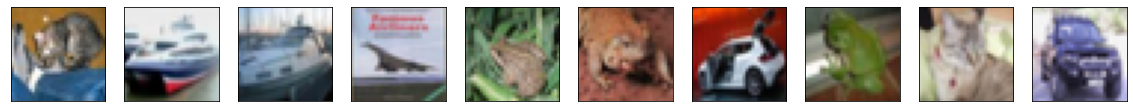

In [10]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
input1 = tfkl.Input((32,32,3))
autoencoder = tfk.Sequential([
  tfkl.InputLayer((32, 32, 3)),                            
  tfkl.Conv2D(filters = 32, kernel_size=3, activation='relu',
              padding="same", input_shape=(32,32,3)),
  tfkl.MaxPool2D(pool_size = (2), padding='same'),
  tfkl.Conv2D(filters = 32, kernel_size=3, activation='relu',
              padding="same"),
  tfkl.MaxPool2D(pool_size = (2), padding='same'),
  tfkl.Conv2D(filters = 32, kernel_size=3, activation='relu', 
              padding='same'),
  tfkl.MaxPool2D(pool_size = (2), padding='same'),


  tfkl.Conv2D(filters = 32, kernel_size=3, activation='relu',
              padding="same"),
  tfkl.UpSampling2D(size = (2, 2)),
  tfkl.Conv2D(filters = 32, kernel_size=3, activation='relu',
              padding="same"),
  tfkl.UpSampling2D(size = (2,2)),
  tfkl.Conv2D(filters = 32, kernel_size=3,  
              padding="same", activation='relu'),
  tfkl.UpSampling2D(size = (2,2)),
  tfkl.Conv2D(filters = 3, kernel_size=1,  activation='sigmoid', padding='same'),
])
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 32)         

In [13]:
autoencoder.compile(optimizer='adam', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [14]:
results = autoencoder.fit(x_train, x_train, 
                          epochs=20,
                          steps_per_epoch=10,
                          batch_size=1000)

Epoch 1/20
10/10 [==============================] - 23s 2s/step - loss: 0.6896 - accuracy: 0.4544
Epoch 2/20
10/10 [==============================] - 20s 2s/step - loss: 0.6659 - accuracy: 0.4951
Epoch 3/20
10/10 [==============================] - 21s 2s/step - loss: 0.6397 - accuracy: 0.4864
Epoch 4/20
10/10 [==============================] - 21s 2s/step - loss: 0.6255 - accuracy: 0.5066
Epoch 5/20
10/10 [==============================] - 21s 2s/step - loss: 0.6154 - accuracy: 0.5374
Epoch 6/20
10/10 [==============================] - 21s 2s/step - loss: 0.6096 - accuracy: 0.5695
Epoch 7/20
10/10 [==============================] - 21s 2s/step - loss: 0.6048 - accuracy: 0.5828
Epoch 8/20
10/10 [==============================] - 20s 2s/step - loss: 0.6035 - accuracy: 0.5916
Epoch 9/20
10/10 [==============================] - 20s 2s/step - loss: 0.6007 - accuracy: 0.6017
Epoch 10/20
10/10 [==============================] - 20s 2s/step - loss: 0.5996 - accuracy: 0.6039
Epoch 11/20
10/10 [

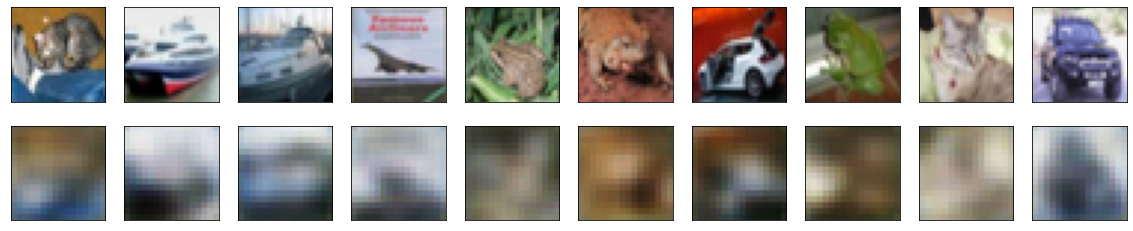

In [17]:
# visulizations of the result
n = 10
decoded = autoencoder.predict(x_test)
plt.figure(figsize=(20, 4))
for i in range(n):
    # original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2 Image Classiﬁcation

In [4]:
## 2.1 deep CNN
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
input1 = tfkl.Input((32,32,3))
model = tfk.Sequential([
    tfkl.InputLayer((32, 32, 3)),                            
    tfkl.Conv2D(filters = 64, kernel_size=3, activation='relu', input_shape=(32,32,3)),
    tfkl.MaxPool2D((2,2)),
    tfkl.Dropout(0.3),
    tfkl.Conv2D(filters = 32, kernel_size= 3, activation='relu'),
    tfkl.MaxPool2D((2,2)),
    tfkl.Dropout(0.3),
    # flatten
    tfkl.Flatten(),
    tfkl.Dense(64, activation='relu'),
    tfkl.Dropout(0.3),
    tfkl.Dense(10, activation='softmax')          
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [13]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=1000, validation_data=(x_test,y_test))

Epoch 1/10
50/50 [==============================] - 69s 1s/step - loss: 1.0150 - accuracy: 0.6506 - val_loss: 0.9151 - val_accuracy: 0.6943
Epoch 2/10
50/50 [==============================] - 68s 1s/step - loss: 0.9854 - accuracy: 0.6581 - val_loss: 0.8651 - val_accuracy: 0.7069
Epoch 3/10
50/50 [==============================] - 68s 1s/step - loss: 0.9745 - accuracy: 0.6627 - val_loss: 0.9223 - val_accuracy: 0.6875
Epoch 4/10
50/50 [==============================] - 69s 1s/step - loss: 0.9675 - accuracy: 0.6639 - val_loss: 0.8877 - val_accuracy: 0.7002
Epoch 5/10
50/50 [==============================] - 68s 1s/step - loss: 0.9624 - accuracy: 0.6653 - val_loss: 0.8549 - val_accuracy: 0.7119
Epoch 6/10
50/50 [==============================] - 69s 1s/step - loss: 0.9597 - accuracy: 0.6665 - val_loss: 0.8817 - val_accuracy: 0.7040
Epoch 7/10
50/50 [==============================] - 68s 1s/step - loss: 0.9470 - accuracy: 0.6675 - val_loss: 0.8500 - val_accuracy: 0.7120
Epoch 8/10
50/50 [==

In [14]:
# performance
score_train = model.evaluate(x_train, y_train, verbose=0)
score_test = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy for train set:", score_train[1])
print("Accuracy for test set:", score_test[1])

Accuracy for train set: 0.7047399878501892
Accuracy for test set: 0.6668000221252441


In [16]:
## 2.2 Transfer Learning
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(32,32,3))
conv_base.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

In [17]:
model = tfk.Sequential([
    tfkl.InputLayer((32,32,3)),
    conv_base,
    tfkl.Flatten(),
    tfkl.Dense(64, activation='relu'),
    tfkl.Dropout(0.5),
    tfkl.Dense(10, activation='softmax')                 
])
conv_base.trainable = False
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 14,748,170
Trainable params: 33,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
results = model.fit(x_train, y_train, epochs=5, batch_size=2000)

Epoch 1/5
25/25 [==============================] - 312s 12s/step - loss: 1.5963 - accuracy: 0.4424
Epoch 2/5
25/25 [==============================] - 305s 12s/step - loss: 1.5514 - accuracy: 0.4602
Epoch 3/5
25/25 [==============================] - 302s 12s/step - loss: 1.5180 - accuracy: 0.4739
Epoch 4/5
25/25 [==============================] - 300s 12s/step - loss: 1.4938 - accuracy: 0.4824
Epoch 5/5
25/25 [==============================] - 301s 12s/step - loss: 1.4692 - accuracy: 0.4893


In [ ]:
# performance
score_train = model.evaluate(x_train, y_train, verbose=0)
score_test = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy for train set:", score_train[1])
print("Accuracy for test set:", score_test[1])

## 3 Text Classiﬁcation

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
df = pd.read_csv('SPAM_detection.csv')
df

In [ ]:
text = np.asarray(df['Message'])
label = np.asarray(df['category_val'])
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.2)

In [ ]:
# tokenize
MAX_NUM_WORDS = 500 
MAX_SEQUENCE_LENGTH = 50 

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(text_train)
train_sequences = tokenizer.texts_to_sequences(text_train) 
test_sequences = tokenizer.texts_to_sequences(text_test)

text_train2 = pad_sequences(train_sequences,maxlen=MAX_SEQUENCE_LENGTH)
text_test2 = pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
train_text = text_train_2[:50000]
train_label = label_train[:50000]
val_text = text_train_2[50000:]
val_label = label_train[50000:]

In [ ]:
## 3.1 RNN
text_RNN = tfk.Sequential([
  tfkl.Embedding(MAX_NUM_WORDS, 64)),
  tfkl.LSTM(32),
  tfkl.Dropout(0.5),
  tfkl.Dense(15, activation="softmax")
])
text_RNN.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
text_RNN.summary()

In [ ]:
textRNN = text_RNN.fit(train_text,train_label,epochs = 10, batch_size = 1000, validation_data = (val_text, val_label))

In [ ]:
RNN_loss, RNN_acc = text_RNN.evaluate(text_test_2, label_test)
print('Accuracy for test set: %.2f%%' % (RNN_acc*100))

In [ ]:
## 3.2 CNN
text_CNN = tfk.Sequential([
  tfkl.Embedding(MAX_NUM_WORDS, 64)),
  tfkl.Conv1D(64, kernel_size = 3,padding='valid',activation='relu',strides=1),
  tfkl.GlobalMaxPool1D(),
  tfkl.Dropout(0.2),
  tfkl.Dense(64, activation="relu"),
  tfkl.Dense(15,activation='softmax')
])
text_CNN.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
text_CNN.summary()

In [ ]:
textCNN = text_CNN.fit(train_text,train_label, epochs = 10,  batch_size = 1000, validation_data = (val_text, val_label))

In [ ]:
CNN_loss, CNN_acc = text_CNN.evaluate(text_test_2, label_test)
print('Accuracy for test set: %.2f%%' % (CNN_acc*100))

In [ ]:
## 3.2 compare CNN and RNN
plt.plot(textRNN.history['acc'])
plt.plot(textRNN.history['val_acc'])
plt.title('Accuracy of RNN model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.plot(textCNN.history['acc'])
plt.plot(textCNN.history['val_acc'])
plt.title('Accuracy of CNN model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()